In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

In [2]:
df_combined = pd.read_csv('combined_data_BlendingRFpreds.csv')

In [3]:
del df_combined['Actual Is_laundering']
df_combined.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,Predicted BlendingRF_M
0,0.228450,-0.815028,-0.932483,-1.000000,-0.332644,0.171435,0.23455,0.156459,0.226096,0.318189,1.000000,0
1,0.555261,-0.738835,-1.000000,-0.769014,-0.339397,0.171435,0.23455,0.156459,0.226096,-1.000000,1.000000,0
2,0.687549,1.000000,1.000000,0.393095,0.295608,0.171435,0.23455,0.156459,0.226096,-0.156956,-0.989758,0
3,1.000000,0.623569,-0.027022,-0.506008,-0.229645,0.171435,0.23455,0.156459,0.226096,0.318189,1.000000,1
4,0.642498,-0.640871,1.000000,-0.730042,0.128140,0.171435,0.23455,0.156459,0.226096,-1.000000,-0.989758,0


In [4]:
df_combined.shape

(4747490, 12)

In [5]:
df_combined['Predicted BlendingRF_M'].value_counts()

1    2379817
0    2367673
Name: Predicted BlendingRF_M, dtype: int64

# Separate DataFrames for Transactions

In [6]:
# Laundering transactions denoted as 1
t_anom = df_combined[df_combined["Predicted BlendingRF_M"]==1]

# Normal transactions denoted as 0
t_norm = df_combined[df_combined["Predicted BlendingRF_M"]==0]

In [7]:
del t_anom['Predicted BlendingRF_M'] 
t_anom.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type
3,1.000000,0.623569,-0.027022,-0.506008,-0.229645,0.171435,0.234550,0.156459,0.226096,0.318189,1.0
10,-0.739408,0.768883,0.828710,-0.572729,0.052975,-1.000000,0.624213,0.156459,0.226096,-0.156956,-1.0
11,-0.849538,-0.551934,0.985206,1.000000,0.046338,0.171435,-1.000000,0.156459,-1.000000,0.793335,1.0
12,1.000000,1.000000,0.205190,0.704854,-0.156396,0.171435,0.234550,0.156459,0.226096,-0.156956,1.0
13,-0.125411,0.981866,-0.572348,0.822753,-0.138024,-1.000000,0.234550,-1.000000,0.226096,0.793335,1.0


In [15]:
t_anom.shape

(2379817, 11)

# Clustering - Laundering Transactions

In [9]:
######################################################
###             Hierarchical Clustering            ###
######################################################

from sklearn.cluster import AgglomerativeClustering

X = t_anom.sample(frac=0.02, replace=False, random_state=0)

# setting distance_threshold=0 ensures we compute the full tree.
cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

#change the parameters
#cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit(X)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

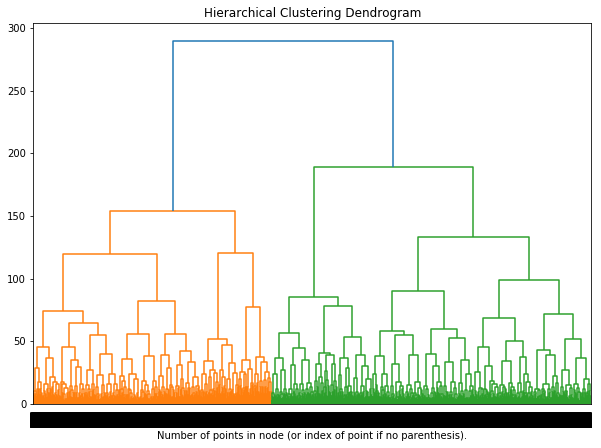

In [10]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    


plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(cluster)
# plot the top three levels of the dendrogram
#plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [11]:
cluster.labels_

array([33795, 43368, 34192, ...,     6,     2,     0])

In [12]:
#change the parameters
cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
cluster.fit_predict(X)

array([0, 1, 1, ..., 1, 0, 0])

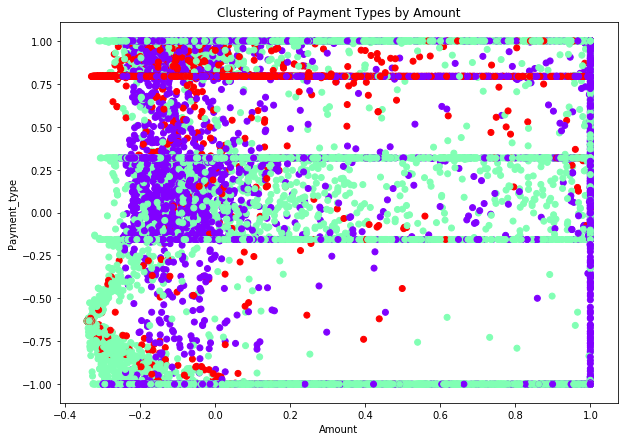

In [14]:
plt.figure(figsize=(10, 7))
plt.scatter(X['Amount'],X['Payment_type'], c=cluster.labels_, cmap='rainbow')

# Add a title to the plot
plt.title('Clustering of Payment Types by Amount')

# Label the axes
plt.xlabel('Amount')
plt.ylabel('Payment_type')

# Display the plot
plt.show()

In [15]:
#append dataframe with cluster number
X['cluster_no'] = cluster.labels_

In [16]:
X.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,cluster_no
4329074,-0.425258,0.280800,0.873196,-1.000000,-0.167180,0.171435,-1.00000,0.156459,0.226096,1.000000,1.0,0
2582872,-0.733486,-1.000000,-0.386757,-1.000000,-0.334415,0.171435,0.23455,0.156459,0.226096,-0.632102,-1.0,1
4516028,0.960607,-0.186152,-0.824081,1.000000,0.027222,0.171435,0.23455,0.156459,0.226096,-1.000000,-1.0,1
3354274,-1.000000,1.000000,0.789285,0.996156,-0.106071,0.171435,0.23455,0.156459,0.226096,0.318189,-1.0,1
1678435,0.209771,1.000000,-0.858983,-1.000000,-0.202235,0.171435,0.23455,0.156459,0.226096,-1.000000,1.0,0


In [17]:
X['cluster_no'].value_counts()

0    20366
1    18690
2     8540
Name: cluster_no, dtype: int64

In [18]:
#save each cluster data separately
# t_anom = df_normt[df_normt["Is_laundering"]==1]
cluster1= X[X['cluster_no']==0]
cluster2= X[X['cluster_no']==1]
cluster3= X[X['cluster_no']==2]

In [19]:
cluster1.keys()

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Laundering_type',
       'cluster_no'],
      dtype='object')

In [20]:
cluster1.describe()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,cluster_no
count,20366.000000,20366.000000,20366.000000,20366.000000,20366.000000,20366.000000,20366.000000,20366.000000,20366.000000,20366.000000,20366.000000,20366.0
mean,-0.049760,0.037249,0.004231,-0.034054,-0.026166,-0.030485,0.004590,0.011592,0.026341,0.028192,0.869783,0.0
std,0.715591,0.789483,0.747438,0.755859,0.330235,0.453103,0.491882,0.382745,0.449607,0.813653,0.493447,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.301962,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0
25%,-0.759904,-0.783429,-0.779845,-0.801777,-0.201222,0.171435,0.234550,0.156459,0.226096,-1.000000,1.000000,0.0
50%,-0.074383,0.043264,-0.001797,-0.139556,-0.139125,0.171435,0.234550,0.156459,0.226096,0.318189,1.000000,0.0
75%,0.627292,0.934055,0.803889,0.808044,-0.037545,0.171435,0.234550,0.156459,0.226096,0.793335,1.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.752101,0.643864,1.000000,1.000000,0.0


In [21]:
cluster2.describe()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,cluster_no
count,18690.000000,18690.000000,18690.000000,18690.000000,18690.000000,18690.000000,18690.000000,18690.000000,18690.000000,18690.000000,18690.0,18690.0
mean,-0.004965,0.039617,0.047013,0.009216,-0.018215,0.159053,0.248560,0.152932,0.214440,-0.247588,-1.0,1.0
std,0.771908,0.771084,0.777365,0.780235,0.334776,0.150741,0.116764,0.066629,0.141208,0.710985,0.0,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.341298,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,1.0
25%,-0.830912,-0.797343,-0.780189,-0.886192,-0.313611,0.171435,0.234550,0.156459,0.226096,-1.000000,-1.0,1.0
50%,-0.042565,0.051251,0.047856,0.038957,-0.099110,0.171435,0.234550,0.156459,0.226096,-0.632102,-1.0,1.0
75%,0.843835,0.899514,0.893629,0.833570,0.090299,0.171435,0.234550,0.156459,0.226096,0.318189,-1.0,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.743758,0.643864,1.000000,-1.0,1.0


In [22]:
cluster3.describe()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,cluster_no
count,8540.000000,8540.000000,8540.000000,8540.000000,8540.000000,8540.000000,8540.000000,8540.000000,8540.000000,8540.000000,8540.0,8540.0
mean,0.029879,0.092068,0.072460,-0.029890,-0.099873,0.152574,-0.961659,0.150493,-0.828402,0.452198,-1.0,2.0
std,0.774122,0.788245,0.773533,0.803403,0.256176,0.151449,0.138715,0.078867,0.353384,0.606513,0.0,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.341360,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,2.0
25%,-0.810964,-0.759797,-0.761611,-0.948267,-0.286495,0.171435,-1.000000,0.156459,-1.000000,0.400517,-1.0,2.0
50%,0.035588,0.162040,0.172022,-0.103318,-0.160800,0.171435,-1.000000,0.156459,-1.000000,0.793335,-1.0,2.0
75%,0.863611,0.972023,0.915711,0.894666,-0.011047,0.171435,-1.000000,0.156459,-1.000000,0.793335,-1.0,2.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.260969,0.699215,0.588655,1.000000,-1.0,2.0


In [23]:
cluster1_mean = np.array(cluster1.mean())
cluster2_mean = np.array(cluster2.mean())
cluster3_mean = np.array(cluster3.mean())

In [24]:
cluster1_mean

array([-0.04975969,  0.03724896,  0.00423064, -0.03405366, -0.02616576,
       -0.0304854 ,  0.00459034,  0.0115923 ,  0.02634074,  0.02819185,
        0.86978297,  0.        ])

In [25]:
cluster2_mean

array([-0.00496469,  0.03961667,  0.04701253,  0.0092158 , -0.01821521,
        0.15905304,  0.2485599 ,  0.15293189,  0.21444002, -0.24758773,
       -1.        ,  1.        ])

In [26]:
cluster3_mean

array([ 0.02987879,  0.09206777,  0.07246009, -0.02988984, -0.09987285,
        0.15257448, -0.96165901,  0.1504929 , -0.82840183,  0.45219784,
       -1.        ,  2.        ])

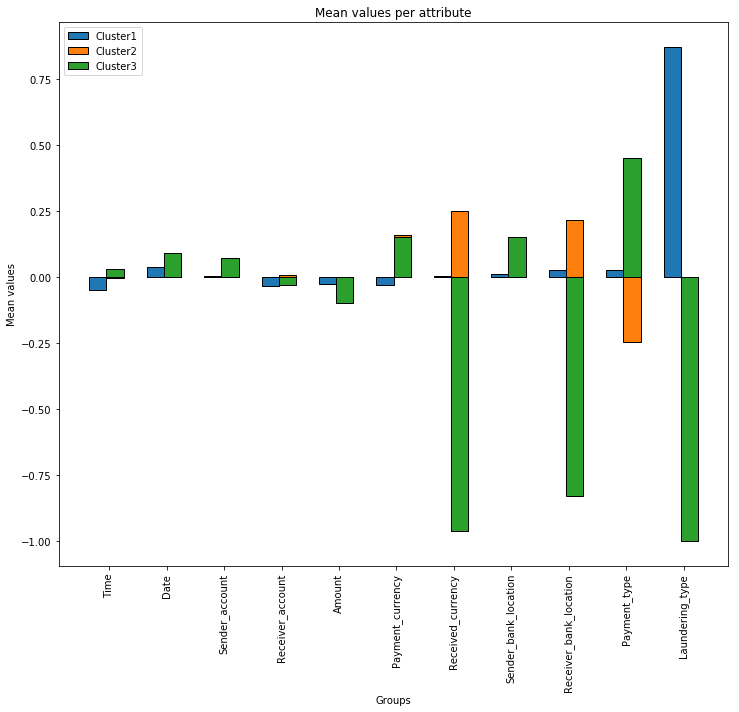

In [31]:
X_m = cluster1.keys()[:-1]

plt.figure(figsize=(12, 10))
  
X_axis = np.arange(len(X_m))

# Ensure the means are also sliced to match the number of keys
cluster1_mean_sliced = cluster1_mean[:-1]
cluster2_mean_sliced = cluster2_mean[:-1]
cluster3_mean_sliced = cluster3_mean[:-1]
  
plt.bar(X_axis - 0.2, cluster1_mean_sliced, 0.3, label = 'Cluster1', edgecolor='black')
plt.bar(X_axis + 0.1, cluster2_mean_sliced, 0.3, label = 'Cluster2', edgecolor='black')
plt.bar(X_axis + 0.1, cluster3_mean_sliced, 0.3, label = 'Cluster3', edgecolor='black')
  
plt.xticks(X_axis, X, rotation='vertical')
plt.xlabel("Groups")
#plt.subplots_adjust(bottom=0.1)
plt.ylabel("Mean values")
plt.title("Mean values per attribute")
plt.legend()
plt.show()

In [32]:
X['cluster_no'].value_counts()

0    20366
1    18690
2     8540
Name: cluster_no, dtype: int64

In [33]:
# Mapping the cluster names
cluster_names = {
    0: 'Laundering with various activities',
    1: 'Laundering with Typical Transactions',
    2: 'Laundering with Various Currencies'
}

X['cluster_no'] = X['cluster_no'].map(cluster_names)

In [35]:
X.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,cluster_no
4329074,-0.425258,0.280800,0.873196,-1.000000,-0.167180,0.171435,-1.00000,0.156459,0.226096,1.000000,1.0,Laundering with various activities
2582872,-0.733486,-1.000000,-0.386757,-1.000000,-0.334415,0.171435,0.23455,0.156459,0.226096,-0.632102,-1.0,Laundering with Typical Transactions
4516028,0.960607,-0.186152,-0.824081,1.000000,0.027222,0.171435,0.23455,0.156459,0.226096,-1.000000,-1.0,Laundering with Typical Transactions
3354274,-1.000000,1.000000,0.789285,0.996156,-0.106071,0.171435,0.23455,0.156459,0.226096,0.318189,-1.0,Laundering with Typical Transactions
1678435,0.209771,1.000000,-0.858983,-1.000000,-0.202235,0.171435,0.23455,0.156459,0.226096,-1.000000,1.0,Laundering with various activities


In [36]:
# Save the DataFrame to a CSV file
X.to_csv('clusterstypes_t.csv', index=False)

# Multi Classififcation

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [40]:
df = pd.read_csv('clusterstypes_t.csv')

In [41]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type,cluster_no
0,-0.425258,0.280800,0.873196,-1.000000,-0.167180,0.171435,-1.00000,0.156459,0.226096,1.000000,1.0,Laundering with various activities
1,-0.733486,-1.000000,-0.386757,-1.000000,-0.334415,0.171435,0.23455,0.156459,0.226096,-0.632102,-1.0,Laundering with Typical Transactions
2,0.960607,-0.186152,-0.824081,1.000000,0.027222,0.171435,0.23455,0.156459,0.226096,-1.000000,-1.0,Laundering with Typical Transactions
3,-1.000000,1.000000,0.789285,0.996156,-0.106071,0.171435,0.23455,0.156459,0.226096,0.318189,-1.0,Laundering with Typical Transactions
4,0.209771,1.000000,-0.858983,-1.000000,-0.202235,0.171435,0.23455,0.156459,0.226096,-1.000000,1.0,Laundering with various activities


In [43]:
df.shape

(47596, 12)

In [46]:
df.notnull().sum()

Time                      47596
Date                      47596
Sender_account            47596
Receiver_account          47596
Amount                    47596
Payment_currency          47596
Received_currency         47596
Sender_bank_location      47596
Receiver_bank_location    47596
Payment_type              47596
Laundering_type           47596
cluster_no                47596
dtype: int64

In [47]:
df.isnull().sum()

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Laundering_type           0
cluster_no                0
dtype: int64

In [51]:
# Setting Features 
feature_cols = [item for item in df.columns if item != 'cluster_no']
X = df[feature_cols]
X.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Laundering_type
0,-0.425258,0.280800,0.873196,-1.000000,-0.167180,0.171435,-1.00000,0.156459,0.226096,1.000000,1.0
1,-0.733486,-1.000000,-0.386757,-1.000000,-0.334415,0.171435,0.23455,0.156459,0.226096,-0.632102,-1.0
2,0.960607,-0.186152,-0.824081,1.000000,0.027222,0.171435,0.23455,0.156459,0.226096,-1.000000,-1.0
3,-1.000000,1.000000,0.789285,0.996156,-0.106071,0.171435,0.23455,0.156459,0.226096,0.318189,-1.0
4,0.209771,1.000000,-0.858983,-1.000000,-0.202235,0.171435,0.23455,0.156459,0.226096,-1.000000,1.0


In [55]:
# Setting Target
y = df['cluster_no']
y.value_counts()

Laundering with various activities      20366
Laundering with Typical Transactions    18690
Laundering with Various Currencies       8540
Name: cluster_no, dtype: int64

In [56]:
# Spliting data into training and testing samples

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

In [59]:
from sklearn.tree import DecisionTreeClassifier


# initialize the Decision classifier
DT = DecisionTreeClassifier(random_state=0)

#fit the classifier to the data
dt_model = DT.fit(X_train, y_train)

#use the resulting model to predict value on the test sey
dt_predictions = DT.predict(X_test)


#performance metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

print(confusion_matrix(y_test, dt_predictions), '\n')
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, dt_predictions))
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, dt_predictions))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, dt_predictions)), '\n')

print(classification_report(y_test, dt_predictions))
print("Accuracy:", accuracy_score(y_test, dt_predictions))
#print("AUC:", roc_auc_score(y_test, dt_predictions))

[[ 9318    10    27]
 [    7  4153     2]
 [   11     7 10263]] 

                                      precision    recall  f1-score   support

Laundering with Typical Transactions       1.00      1.00      1.00      9355
  Laundering with Various Currencies       1.00      1.00      1.00      4162
  Laundering with various activities       1.00      1.00      1.00     10281

                            accuracy                           1.00     23798
                           macro avg       1.00      1.00      1.00     23798
                        weighted avg       1.00      1.00      1.00     23798

Accuracy: 0.997310698378015


In [60]:
#performance metrics

from sklearn.model_selection import cross_val_predict

#predicted values
y_pred = cross_val_predict(DT, X, y, cv=20)

print(confusion_matrix(y, y_pred), '\n')
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_ts_ens, y_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_ts_ens, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_ts_ens, y_pred)), '\n')

print(classification_report(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))
#print("AUC:", roc_auc_score(y_ts_ens, y_pred))

[[18656    15    19]
 [   18  8514     8]
 [   19     8 20339]] 

                                      precision    recall  f1-score   support

Laundering with Typical Transactions       1.00      1.00      1.00     18690
  Laundering with Various Currencies       1.00      1.00      1.00      8540
  Laundering with various activities       1.00      1.00      1.00     20366

                            accuracy                           1.00     47596
                           macro avg       1.00      1.00      1.00     47596
                        weighted avg       1.00      1.00      1.00     47596

Accuracy: 0.998172115303807
